# Final NF2FF (MATLAB Clone)

This notebook presents my finalized method for the NF2FF transformation in Python. This begins by setting up the gridding, and using the imported data from the MATLAB script. It ultimately produces the same FF results as the MATLAB code and includes 2 important functions, `NFtoFourierSpace` and `FFtoFourier`. These functions are going to by placed into an external Python file called `NF2FF_Tools.py`, along with the `electric_field_errors` function.

In [1]:
## CLONING the NF2FF Script from MATLAB: https://www.mathworks.com/matlabcentral/fileexchange/23385-nf2ff

## import statements:
import numpy as np
from matplotlib.pyplot import *
from numpy.fft import fft2
from numpy.fft import ifft2
from numpy.fft import fftshift
from numpy.fft import ifftshift

import pandas
from matplotlib.colors import LogNorm

from scipy.interpolate import RectBivariateSpline

In [2]:
def RegularGridding(x,y,dtheta,dphi):
    '''
    Produces k-space grid and parameters for given x, y vectors (this may only work for the traditional 
    NF2FF case, not offsets).'''
    
    M = len(x)
    N = len(y)
    dx = x[1] - x[0]
    dy = y[1] - y[0]
    
    # setting up k-space, theta, phi grids
    # See equations (16-13a) and (16-13b) in Balanis
    # Zero padding is used to increase the resolution of the plane wave spectral domain.
    MI=4*M;#2^(ceil(log2(M))+1);
    NI=4*N;#2^(ceil(log2(N))+1);
    m=np.linspace(-MI/2,MI/2-1,MI);
    n=np.linspace(-NI/2,NI/2-1,NI)
    k_X_Rectangular=(2*np.pi*m)/(MI*dx);
    k_Y_Rectangular=(2*np.pi*n)/(NI*dy);
    theta=np.arange(-np.pi/2+dtheta,np.pi/2-dtheta,dtheta);
    phi=np.arange(0+dphi,np.pi-dphi,dphi);
    [theta,phi]=np.meshgrid(theta,phi);

    return [m,n,k_X_Rectangular,k_Y_Rectangular,theta,phi]

In [3]:
def NyquistSampling(broadcast_freq):
    '''
    Returns the Nyquist spacing in m for broadcasting at a given frequency (input as broad_freq).
    '''

    c=299792458.0 # Speed of light in vacuum [m/s]

    lambda_m=c/broadcast_freq
    nyquist_sampling_m=lambda_m/2; # necessary grid spacing in m

    return nyquist_sampling_m

def Calculate_k0(freq):
    '''
    Returns the k0 wave number for measurements at a certain frequency (input as freq).
    '''

    c=299792458.0 # Speed of light in vacuum [m/s]

    # calculating k0
    lambda0=c/freq;
    k0=2*np.pi/lambda0;

    return k0

In [4]:
def NFtoFourier (NF_X,NF_Y,kx,ky,k0,plotFourier=False):
    
    '''Function to bring NF data into k-space (plane wave spectrum). Returns a list that returns 
    plane wave spectrum in x, y, z polarizations, along with their respective magnitudes.
    Input parameters:
    NF_X and NF_Y: NF data in x and y polarizations on a rectangular grid
    kx and ky: spectral frequency vector components
    k0: wave number
    plotFourier: if True, plots the plane wave spectrum over the k-space grid'''
    
    [kx_grid,ky_grid]=np.meshgrid(kx,ky)
    
    grid_size = np.shape(kx_grid)
    MI = grid_size[0]
    NI = grid_size[1]
    
    kz_grid=np.emath.sqrt((k0**2.0)-(kx_grid**2.0)-(ky_grid**2.0));
    fx=ifftshift(ifft2(NF_X,[MI,NI],axes=[0,1]))
    fy=ifftshift(ifft2(NF_Y,[MI,NI],axes=[0,1]))
    fz=(-1.0*((fx*kx_grid)+(fy*ky_grid)))/kz_grid
    
    # this magnitude is not in dB, can be plotted in dB by taking log and multiplying by 20 or simply using lognorm plotting
    fx_magnitude=(np.abs(fx));
    fy_magnitude=(np.abs(fy));
    fz_magnitude=(np.abs(fz));
    
    if plotFourier == True:
        fig,[ax1,ax2,ax3]=subplots(nrows=1,ncols=3,figsize=(16,5.5))
        ax1.pcolormesh(kx_grid,ky_grid,fx_magnitude,cmap='gnuplot2',norm=LogNorm())
        ax2.pcolormesh(kx_grid,ky_grid,fy_magnitude,cmap='gnuplot2',norm=LogNorm())
        ax3.pcolormesh(kx_grid,ky_grid,fz_magnitude,cmap='gnuplot2',norm=LogNorm())
        ax1.set_aspect('equal')
        ax2.set_aspect('equal')
        ax3.set_aspect('equal')
        tight_layout()

    return [fx, fy, fz, fx_magnitude, fy_magnitude, fz_magnitude]

In [12]:
def FouriertoFF(f_x,f_y,f_z,theta,phi,k_x,k_y,k0,FFOutputs=False):

    '''Brings data from plave wave spectrum to the far-field pattern, by first inteprolating the data into
    spherical, then applying transformation.
    Returns list with [Etheta,Ephi]
    Input parameters:
    f_x, f_y, f_z: plane wave spectrum in x, y, z polarizations
    theta: vector of theta values for spherical coordinates
    phi: vector of phi values for spherical coordinates
    k_x and k_y: spectral frequency vector components
    k0: wave number (2pi/lambda0)
    plotFourier: if True, plots final FF pattern'''

    xx = k0*np.sin(theta)*np.cos(phi)
    yy = k0*np.sin(theta)*np.sin(phi)

    f_x_interp = RectBivariateSpline(k_x,k_y,np.abs(f_x.T))
    f_y_interp = RectBivariateSpline(k_x,k_y,np.abs(f_y.T))
    f_z_interp = RectBivariateSpline(k_x,k_y,np.abs(f_z.T))

    f_X_Spherical = f_x_interp.ev(xx,yy)
    f_Y_Spherical = f_y_interp.ev(xx,yy)
    f_Z_Spherical = f_z_interp.ev(xx,yy)
    
    print(f_X_Spherical)
    print(f_Y_Spherical)
    print(f_Z_Spherical)

    r=10000;
    C=1.0j*(k0*np.exp(-1.0j*k0*r))/(2*np.pi*r)
    Etheta=C*(f_X_Spherical*np.cos(phi)+f_Y_Spherical*np.sin(phi));
    Ephi=C*np.cos(theta)*(-f_X_Spherical*np.sin(phi)+f_Y_Spherical*np.cos(phi));

    if FFOutputs==True:
        fig=figure(figsize=(9,9))
        ax=fig.add_subplot(2,2,1)
        pcm=ax.pcolormesh(theta,phi,20*np.log10(np.abs(Etheta)),cmap='gnuplot2')
        ax.set_aspect('equal')
        ax.set_title('Etheta')
        ax.set_xlabel('Theta')
        ax.set_ylabel('Phi')
        colorbar(mappable=pcm,ax=ax)
        ax=fig.add_subplot(2,2,2)
        pcm=ax.pcolormesh(theta,phi,20*np.log10(np.abs(Ephi)),cmap='gnuplot2')
        ax.set_aspect('equal')
        ax.set_title('Ephi')
        ax.set_xlabel('Theta')
        ax.set_ylabel('Phi')
        colorbar(mappable=pcm,ax=ax)
        ax=fig.add_subplot(2,2,3,projection='3d')
        ax.plot_surface(theta,phi,20.0*np.log10(np.abs(Etheta))-np.nanmax(20.0*np.log10(np.abs(Etheta.T.conj()))),cmap='gnuplot2')
        ax.view_init(30,-37.5)
        ax.set_title('Etheta')
        ax.set_xlabel('Theta')
        ax.set_ylabel('Phi')
        ax=fig.add_subplot(2,2,4,projection='3d')
        ax.plot_surface(theta,phi,20.0*np.log10(np.abs(Ephi))-np.nanmax(20.0*np.log10(np.abs(Ephi.T.conj()))),cmap='gnuplot2')
        ax.view_init(30,-37.5)
        ax.set_title('Ephi')
        ax.set_xlabel('Theta')
        ax.set_ylabel('Phi')
        fig.tight_layout()

    return [Etheta,Ephi]


In [13]:
## Specified input parameters from MATLAB folks:
c=299792458.0 # Speed of light in vacuum [m/s]
broadcast_freq=94*10^9 # broadcast frequency in hertz
sdata=np.array(pandas.read_csv('sample_data.csv',header=None)).flatten()
sdata=np.array([complex(x.replace('i','j')) for x in sdata]).reshape((51,51,201))
sdata2=np.array(pandas.read_csv('s21_data2.csv',header=None)).flatten()
sdata2=np.array([complex(x.replace('i','j')) for x in sdata2]).reshape((51,51,201))
freq=np.loadtxt('sample_frequencies.csv',delimiter=',') #Hz
N=len(freq)
f_start=freq[1]
f_stop=freq[-1]
df=(f_stop-f_start)/(N-1)
dt=1.0/(N*df)
t=np.arange(N-1)*dt

In [14]:
# Setting up gridding:
# See equations (16-10a) and (16-10b) in Balanis
M=51#sdata.xpoints; # Amount of samples in the x direction (along table, left to right)
N=51#sdata.ypoints; # Amount of samples in the y direction (across table, front to back)
dx=1/1000#sdata.x_step/1000; # Sample spacing in the x direction [m]
dy=1/1000#sdata.y_step/1000; # Sample spacing in the y direction [m]
# See equations (16-10a) and (16-10b) in Balanis
a=dx*(M-1); # The length of the scanned area in the x direction [m]
b=dy*(N-1); # The length of the scanned area in the y direction [m]
x=np.linspace(-a/2,a/2,M)
y=np.linspace(-b/2,b/2,N)
z0=0.006;

In [15]:
[m,n,k_X_Rectangular,k_Y_Rectangular,theta,phi] = RegularGridding(x,y,0.05,0.05)

In [16]:
find=200
f=freq[find];print(f*1e-9)
lambda0=c/f;
k0=2*np.pi/lambda0;
NF_X_Complex=sdata[:,:,find]
NF_Y_Complex=sdata2[:,:,find]
NF_X_Magnitude = (np.abs(NF_X_Complex));
NF_Y_Magnitude = (np.abs(NF_Y_Complex));
from skimage.restoration import unwrap_phase
NF_X_Phase=unwrap_phase(np.angle(NF_X_Complex),wrap_around=True)
NF_Y_Phase=unwrap_phase(np.angle(NF_Y_Complex),wrap_around=True)

110.0


<ipython-input-17-52fa7a1d1c0c>:5: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  pcm=ax.pcolormesh(x,y,NF_X_Magnitude,cmap='gnuplot2',norm=LogNorm())
<ipython-input-17-52fa7a1d1c0c>:15: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  pcm=ax.pcolormesh(x,y,NF_Y_Magnitude,cmap='gnuplot2',norm=LogNorm())


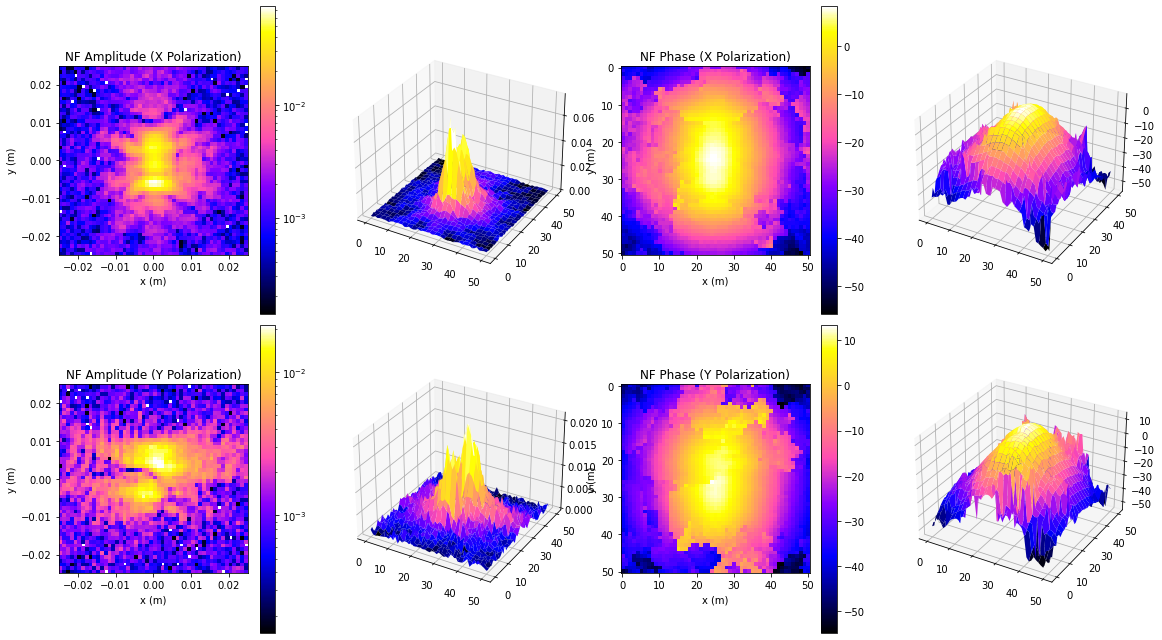

In [17]:
# plotting the NF pattern

fig=figure(figsize=(16,9))
ax=fig.add_subplot(2, 4, 1)
pcm=ax.pcolormesh(x,y,NF_X_Magnitude,cmap='gnuplot2',norm=LogNorm())
ax.set_aspect('equal')
ax.set_title('NF Amplitude (X Polarization)')
ax.set_xlabel('x (m)')
ax.set_ylabel('y (m)')
colorbar(mappable=pcm,ax=ax)
ax=fig.add_subplot(2, 4, 2, projection='3d')
[X,Y]=np.meshgrid(np.arange(51),np.arange(51))
ax.plot_surface(X,Y,NF_X_Magnitude,cmap='gnuplot2',norm=LogNorm())
ax=fig.add_subplot(2, 4, 5)
pcm=ax.pcolormesh(x,y,NF_Y_Magnitude,cmap='gnuplot2',norm=LogNorm())
ax.set_title('NF Amplitude (Y Polarization)')
ax.set_xlabel('x (m)')
ax.set_ylabel('y (m)')
ax.set_aspect('equal')
colorbar(mappable=pcm,ax=ax)
ax=fig.add_subplot(2, 4, 6, projection='3d')
ax.plot_surface(X,Y,NF_Y_Magnitude,cmap='gnuplot2',norm=LogNorm())
tight_layout()

ax=fig.add_subplot(2, 4, 3)
im=ax.imshow(NF_X_Phase,aspect='equal',cmap='gnuplot2')
ax.set_title('NF Phase (X Polarization)')
ax.set_xlabel('x (m)')
ax.set_ylabel('y (m)')
ax.set_aspect('equal')
colorbar(mappable=im,ax=ax)
ax=fig.add_subplot(2, 4, 4, projection='3d')
[X,Y]=np.meshgrid(np.arange(51),np.arange(51))
ax.plot_surface(X,Y,NF_X_Phase,cmap='gnuplot2')
ax=fig.add_subplot(2, 4, 7)
im=ax.imshow(NF_Y_Phase,aspect='auto',cmap='gnuplot2')
ax.set_title('NF Phase (Y Polarization)')
ax.set_xlabel('x (m)')
ax.set_ylabel('y (m)')
ax.set_aspect('equal')
colorbar(mappable=im,ax=ax)
ax=fig.add_subplot(2, 4, 8, projection='3d')
ax.plot_surface(X,Y,NF_Y_Phase,cmap='gnuplot2')
tight_layout()

<ipython-input-4-60aab1aa2621>:29: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax1.pcolormesh(kx_grid,ky_grid,fx_magnitude,cmap='gnuplot2',norm=LogNorm())
<ipython-input-4-60aab1aa2621>:30: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax2.pcolormesh(kx_grid,ky_grid,fy_magnitude,cmap='gnuplot2',norm=LogNorm())
<ipython-input-4-60aab1aa2621>:31: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3. 

[[1.11843265e-06 1.15164618e-06 1.53043431e-06 ... 4.35440188e-06
  3.76092257e-06 3.29519767e-06]
 [2.97300365e-06 3.41653226e-06 4.19805325e-06 ... 2.75494473e-06
  2.21199117e-06 1.96226502e-06]
 [2.75061993e-06 3.24134001e-06 4.09559647e-06 ... 2.96447135e-06
  2.84653476e-06 2.79698925e-06]
 ...
 [2.94966200e-06 3.20755939e-06 3.56391542e-06 ... 4.74149719e-06
  4.27005019e-06 3.89046053e-06]
 [2.97909913e-06 2.98618322e-06 2.88246398e-06 ... 3.81409602e-06
  3.77572769e-06 3.64605806e-06]
 [2.22763330e-06 2.29280005e-06 2.48099922e-06 ... 3.94257759e-06
  3.88512074e-06 3.79588794e-06]]
[[3.75000776e-06 4.29730451e-06 5.21638700e-06 ... 9.00570526e-06
  7.76979334e-06 7.14198856e-06]
 [5.79928313e-06 6.17689915e-06 6.80297850e-06 ... 1.07164064e-05
  1.01146315e-05 9.90523841e-06]
 [5.18430375e-06 5.75782252e-06 6.64482762e-06 ... 1.31455397e-05
  1.23987155e-05 1.18224885e-05]
 ...
 [1.38832273e-06 1.33707501e-06 1.13457596e-06 ... 1.03283849e-05
  9.43633831e-06 8.65040922e-06]

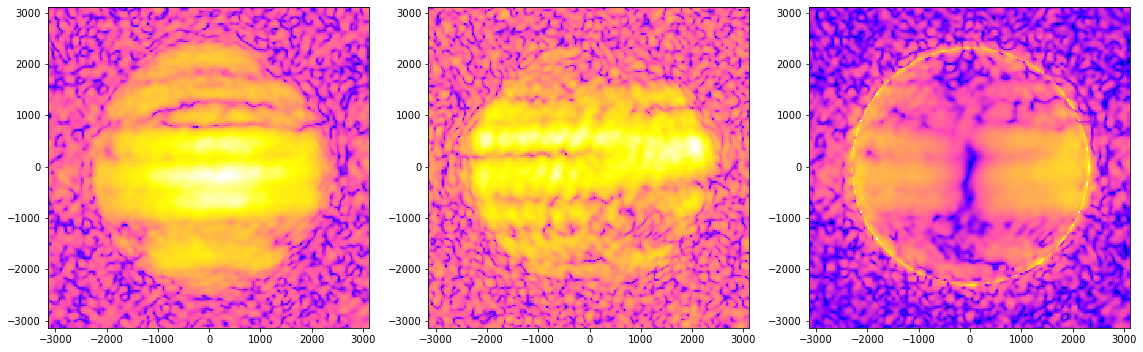

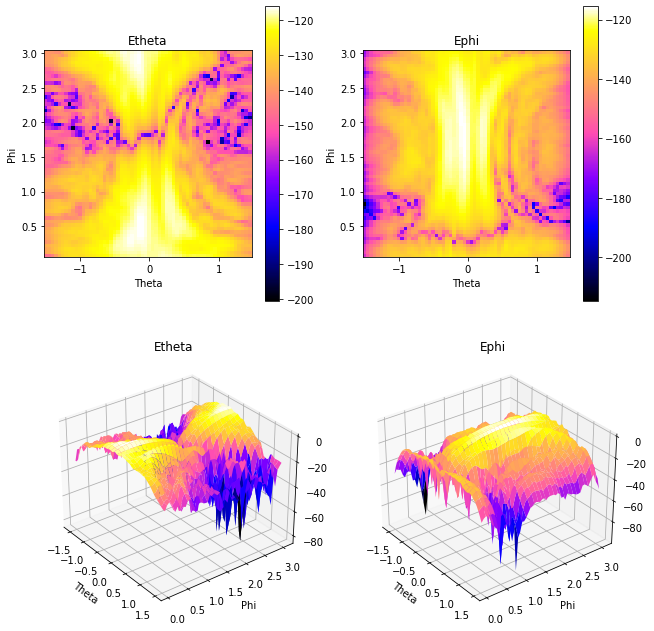

In [18]:
FourierSpace=NFtoFourier(NF_X_Complex,NF_Y_Complex,k_X_Rectangular,k_Y_Rectangular,k0,plotFourier=True)
[Etheta,Ephi]=FouriertoFF(FourierSpace[0],FourierSpace[1],FourierSpace[2],theta,phi,k_X_Rectangular,k_Y_Rectangular,k0,FFOutputs=True)